# This is the Notebook for Detection Transformer



#### first we will create the Dataloader:

In [1]:
#load dataSet
from texbig_dataset import *
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

local_root = "../texbig"
dataset = TexBiGDataset(local_root, "/Annotations/coco_conform_annotations_combined.json")
valDataset=TexBiGDataset(local_root,"/Annotations/coco_conform_annotations_combined_val.json")

trainDataLoader=torch.utils.data.DataLoader(dataset,batch_size=2, num_workers=1,shuffle=True, collate_fn=dataset.collate_fn)
Val_dataLoader=torch.utils.data.DataLoader(valDataset,batch_size=2, num_workers=1,shuffle=True, collate_fn=dataset.collate_fn)






loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [13]:
print(dataset[0])

(tensor([[[-1.1418, -1.0904, -1.1932,  ..., -1.2274, -1.2274, -1.2274],
         [-1.2274, -1.2103, -1.2103,  ..., -1.2445, -1.2274, -1.1932],
         [-1.2445, -1.2274, -1.2103,  ..., -1.2103, -1.2103, -1.1932],
         ...,
         [ 1.4612,  1.4612,  1.4612,  ...,  1.4612,  1.4612,  1.4612],
         [ 1.4612,  1.4612,  1.4612,  ...,  1.4612,  1.4612,  1.4612],
         [ 1.4612,  1.4612,  1.4612,  ...,  1.4612,  1.4612,  1.4612]],

        [[-0.9853, -0.9328, -1.0553,  ..., -1.0903, -1.0903, -1.0728],
         [-1.0728, -1.0553, -1.0553,  ..., -1.1078, -1.0903, -1.0553],
         [-1.1078, -1.0903, -1.0728,  ..., -1.0728, -1.0553, -1.0553],
         ...,
         [ 1.6232,  1.6232,  1.6232,  ...,  1.6232,  1.6232,  1.6232],
         [ 1.6232,  1.6232,  1.6232,  ...,  1.6232,  1.6232,  1.6232],
         [ 1.6232,  1.6232,  1.6232,  ...,  1.6232,  1.6232,  1.6232]],

        [[-0.7761, -0.7238, -0.8458,  ..., -0.8807, -0.8807, -0.8633],
         [-0.8633, -0.8458, -0.8458,  ..., -

#### InputShape of the Network must be list of img and target [img, target] where target is a dict containing variables 'masks' (not necessary), 'labels' [ x ], and 'boxes' [x,4]

#### below the Network is defined

##### Structure: 
![Alt Text](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/05/Screenshot-from-2020-05-27-20-04-48.png)





##### Network Parameter for DETR on TexBig:
Backbone: ResNet50
number of prediction heads= number of total classes +1 (empty class)=18

numQueries= number of predicted rectangle per image: 100

hidden dimensions of ResNet (output of Backbone)
hidden_dim=256

number of attention heads:
nheads=8

dim_feedforward=2048

Number of encoder and Decoder Layers:
enc_layers=6, dec_layers=6 


In [2]:

import torch
import torch.nn as nn
class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x


In [3]:

import torch
import torch.nn as nn
from torchvision.models import resnet50
from matcher import build_matcher
from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)

class DETR(nn.Module):
    def __init__(self, backbone,transformer,num_classes, num_queries, aux_loss=False):
        """ Initializes the model.
        Parameters:
            backbone: torch module of the backbone to be used. See backbone.py
            transformer: torch module of the transformer architecture. See transformer.py
            num_classes: number of object classes
            num_queries: number of object queries, ie detection slot. This is the maximal number of objects
                         DETR can detect in a single image. For COCO, we recommend 100 queries.
            aux_loss: True if auxiliary decoding losses (loss at each decoder layer) are to be used.
        """
        super().__init__()
        self.num_classes=num_classes
        self.backbone = backbone
        
        self.num_queries = num_queries
        self.transformer = transformer #nn.Transformer(256,32,6,6)#(hidden_dim, num_heads,
         #num_enc_layers, num_dec_layers)
        
        hidden_dim = self.transformer.d_model
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
        self.bn1=nn.BatchNorm2d(hidden_dim)
       
        self.aux_loss = aux_loss
        
        #build hungarian matcher
        self.matcher= build_matcher(set_cost_class=1, set_cost_bbox=1, set_cost_giou=2)
        self.weight_dict = {'loss_ce': 1, 'loss_bbox': 5}
        self.weight_dict['loss_giou'] = 2

        self.eos_coef=0.1 #Relative classification weight of the no-object class"

    def forward(self, samples: NestedTensor):
            """ The forward expects a NestedTensor, which consists of:
               - samples.tensor: batched images, of shape [batch_size x 3 x H x W]
               - samples.mask: a binary mask of shape [batch_size x H x W], containing 1 on padded pixels
            It returns a dict with the following elements:
               - "pred_logits": the classification logits (including no-object) for all queries.
                                Shape= [batch_size x num_queries x (num_classes + 1)]
               - "pred_boxes": The normalized boxes coordinates for all queries, represented as
                               (center_x, center_y, height, width). These values are normalized in [0, 1],
                               relative to the size of each individual image (disregarding possible padding).
                               See PostProcess for information on how to retrieve the unnormalized bounding box.
               - "aux_outputs": Optional, only returned when auxilary losses are activated. It is a list of
                                dictionnaries containing the two above keys for each decoder layer.
        """
            
            if isinstance(samples, (list, torch.Tensor)):
                samples = nested_tensor_from_tensor_list(samples)
            features, pos = self.backbone(samples)
           
            #print(features)
            src, mask = features[-1].decompose()
            
            assert mask is not None
            hs = self.transformer(self.bn1(self.input_proj(src)), mask, self.query_embed.weight, pos[-1])[0]
            
            outputs_class = self.class_embed(hs)
            outputs_coord = self.bbox_embed(hs).sigmoid()   #maybe change to relu
            #print(outputs_coord)
                
            out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1]}
           
            
            if self.aux_loss:
                out['aux_outputs'] = self._set_aux_loss(outputs_class, outputs_coord)
            return out
        

        
        
        #for testing###################        
class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results


#### Create an object of the Detection Transformer by defining a build method()


In [4]:
from backbone import build_backbone
from transformer import build_transformer
import argparse

def build():
    num_classes=18
    num_queries=100 
    aux_loss=False
   
    backbone = build_backbone(lr_backbone=1e-5,hidden_dim=256)#,hidden_dim
    transformer = build_transformer(hidden_dim=256,dropout=0.1, nheads=8, dim_feedforward=2048, enc_layers=6, dec_layers=6 , pre_norm=True )
    postprocessors = {'bbox': PostProcess()}
    
    model = DETR(
        backbone,
        transformer,
        num_classes=num_classes,
        num_queries=num_queries,
        aux_loss=aux_loss,
    )
    return model#, postprocessors


device = torch.device('cuda')
model =build().to(device)      



#### and load pretrained weights (ResNet: torch hub; DETR: FB Research )

In [5]:
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

model.load_state_dict(checkpoint["model"], strict=False)
model.eval()

DETR(
  (backbone): Joiner(
    (0): Backbone(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): FrozenBatchNorm2d()
            )
    

### Initialize the Optimizer

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Initialize optimizer

# Initialize learning scheduler
scheduler = StepLR(optimizer, 200)

### Define Loss funcitons (Class: Criterion)
###### Necessary inputparameter: number of classes, matcher object, relative classification weight (stored in model.weight_dict and model.eos_coef) we created with the mentioned build() method

#### Losses can be received by creating an Object of Criterion class and calling criterion.computeLosses()


#### Criterion Contains: 
#### Loss computation 
###### hungarian assignment (for detailed view look into matcher.py)
###### LabelLoss: cross entropy
###### BoxLoss: L1 Loss



In [7]:
from util import box_ops
#define losses, taken from original implementation
#https://github.com/tahmid0007/DETR_FineTune/blob/main/main.py
class SetCriterion(nn.Module):
    """ This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
    """
    
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)
        
    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
            """Classification loss (NLL)
            targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
            """

            #print(indices)
            assert 'pred_logits' in outputs
            src_logits = outputs['pred_logits']
            
            idx = self._get_src_permutation_idx(indices)
            target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
            target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                        dtype=torch.int64, device=src_logits.device)
            target_classes[idx] = target_classes_o

            loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
            losses = {'loss_ce': loss_ce}
            losses={}
            losses['loss_ce']=loss_ce
            
            if log:
                # TODO this should probably be a separate loss, not hacked in this one here
                losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
            return losses


    def loss_boxes(self, outputs, targets, indices, num_boxes):
            """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
               targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
               The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
            """
         
            assert 'pred_boxes' in outputs
            idx = self._get_src_permutation_idx(indices)
            src_boxes = outputs['pred_boxes'][idx]
            target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

            loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

            losses = {}
            losses['loss_bbox'] = loss_bbox.sum() / num_boxes

            loss_giou = 1 - torch.diag(box_ops.generalized_box_iou(
                box_ops.box_cxcywh_to_xyxy(src_boxes),
                box_ops.box_cxcywh_to_xyxy(target_boxes)))
            losses['loss_giou'] = loss_giou.sum() / num_boxes
            return losses
        
        
    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx
    
    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            #'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
            #'masks': self.loss_masks
        }
        assert loss in loss_map 
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)
    
    
    
    def computeLosses(self, outputs,targets):
         outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'} #do we need that?
         #Retrieve the matching between the outputs of the last layer and the targets
         indices = self.matcher(outputs_without_aux, targets)
         # Compute the average number of target boxes accross all nodes, for normalization purposes
         num_boxes = sum(len(t["labels"]) for t in targets)
         num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)  
         num_boxes = torch.clamp(num_boxes / get_world_size(), min=1).item()
          # Compute all the requested losses
         losses = {}
         for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))
         
         
         return losses    

In [8]:
#####calculate AP from COCO metrics######
from ObjectDetectionMetrics.mean_avg_precision import *
from ObjectDetectionMetrics.iou import intersection_over_union
def renormBox(x,y,w,h):
       
        width = 500
        height = 705
        
        
        x1=(x)*width
        x2=(x+w)*width
        y1=(y)*height
        y2=(y+h)*height
        
       
        return (x1,y1,x2,y2)


def calAvp(gt_boxes,gt_labels, pred_results):
    avp=[]
    avp50=0
    avp75=0
    iou_classes=[]
    boxes=pred_results['boxes']
    
  


    x, y, x1, y1 = boxes.unbind(1)
    lbls=pred_results['labels']
    scores=pred_results['scores']
    s=torch.ones(100)
    box1= [s, lbls.cpu(), scores.cpu(), x.int().cpu(), y.int().cpu(), x1.int().cpu(), y1.int().cpu()]
    pred_boxes=torch.stack(box1, dim=1)
    

    
    xT1,yT1,xT2,yT2=gt_boxes.unbind(1)
    l=len(xT1)
    
    xT1,yT1,xT2,yT2=renormBox(xT1.cpu(),yT1.cpu(),xT2.cpu(),yT2.cpu())
    
    gtB=torch.stack([torch.ones(l), gt_labels.cpu(),  torch.ones(l),  xT1, yT1, xT2, yT2],dim=1)
    
    for threshold in range (50, 95, 5):
        thresh=threshold/100
        
        """"pred_boxes (list): list of lists containing all bboxes with each bboxes
            specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
            true_boxes (list): Similar as pred_boxes except all the correct ones"""""
        
        s,iou=mean_average_precision(pred_boxes.cpu(), gtB, thresh, box_format="corners", num_classes=18)
        
        avp.append(s)
        if thresh==0.5:
            avp50=s
            iou_classes=iou
        if thresh==0.75:
            avp75=s            
        
    return(sum(avp)/len(avp)), avp50, avp75,iou_classes


### lets define a training and a validation loop 

In [9]:

import torch.nn.functional as F
import math

post=PostProcess()
# Define training loop
def train(model, device, train_loader, optimizer, epoch, criterion):
    plotlosses = PlotLosses()
    model.train()
    logs = {}
    epochLoss=[]
    epochBoxLoss=[]
    epochAcc=[]
    Avp=[]
    Avp50=[]
    Avp75=[]
    iou_classes=[]
    running_loss = 0.0
    running_corrects = 0
    running_count=0
    max_norm =0.1#'gradient clipping max norm'
    losses = [ 'boxes','labels']
    
    #torch.autograd.set_detect_anomaly(True)
    for batch_idx, (data, target) in enumerate(train_loader):  
        
            
                        target=target[0]
                        data=torch.stack(data).to(device)
                        box1=target['boxes'][0].to(device)
                        box2=target['boxes'][1].to(device)
                        label1=target['labels'][0].to(device)
                        label2=target['labels'][1].to(device)

                        target= [ {  'labels': label1, 'boxes':box1 },  {  'labels': label2, 'boxes':box2 }]
                        
                        #print(target)
                        output = model(data)

                        loss_dict   = criterion.computeLosses(output,target)
                        
                        weight_dict = criterion.weight_dict
                        epochBoxLoss.append(loss_dict['loss_bbox'])

                            
                        #print(loss_dict)
                        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
                     
                            
                        loss_dict_reduced = utils.reduce_dict(loss_dict)
                        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                                      for k, v in loss_dict_reduced.items()}
                        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
                        losses_reduced_scaled = sum(loss_dict_reduced_scaled.values())

                        loss_value = losses_reduced_scaled.item()

                        if not math.isfinite(loss_value):
                            print("Loss is {}, stopping training".format(loss_value))
                            print(loss_dict_reduced)
                            sys.exit(1)

                        optimizer.zero_grad()
                        losses.backward()
                        if max_norm > 0:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
                        optimizer.step()

                        running_loss += losses.detach() * data.size(0)
                        epochLoss.append(losses)
                        
                        #calculate AP 
                        target_sizes=torch.tensor([705,500])#.unsqueeze(0)
                        target_sizes=torch.stack((target_sizes,target_sizes)) 
                        
                        results=post(output, target_sizes.to(torch.cuda.current_device()))
                        res1={'labels': results[0]['labels'], 'boxes':results[0]['boxes'],'scores': results[0]['scores']}
                        res2={'labels': results[1]['labels'], 'boxes':results[1]['boxes'],'scores': results[1]['scores']}
                                      
                            
                        avp,avp50,avp75,iou=calAvp(box1,label1, res1)
                        Avp.append(avp)
                        Avp50.append(avp50)
                        Avp75.append(avp75)
                        iou_classes.append(iou)

                            
                        avp,avp50,avp75,iou=calAvp(box2,label2, res2)
                        Avp.append(avp)
                        Avp50.append(avp50)
                        Avp75.append(avp75)
                        iou_classes.append(iou)
                       

                        if batch_idx % 100 == 0:
                            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                                epoch, batch_idx * len(data), len(train_loader.dataset),
                                100. * batch_idx / len(train_loader), losses.item()))


    return sum(epochLoss)/len(epochLoss), sum(epochBoxLoss)/len(epochBoxLoss), sum(Avp)/len(Avp),sum(Avp50)/len(Avp50),sum(Avp75)/len(Avp75), sum(iou_classes)/len(iou_classes)


In [10]:
from tqdm import tqdm
post=PostProcess()

def Validation(model, device, Val_loader, criterion):
    
    logs = {}
    epochLoss=[]
    epochAcc=[]
    epochClassLoss = {}
    Avp=[]
    Avp50=[]
    Avp75=[]
    iou_classes=[]
    running_loss = 0.0
    running_corrects = 0
    running_count=0
    torch.cuda.empty_cache()
    with torch.no_grad():
   
        net=model
      

        for batch_idx, (data, target) in tqdm(enumerate(Val_loader)):
            if batch_idx<117: #because we have 235 images, last batch causes error (batch size of 2)
                
                target=target[0]
                data=torch.stack(data).to(device)
                box1=target['boxes'][0].to(device)
                box2=target['boxes'][1].to(device)
                label1=target['labels'][0].to(device)
                label2=target['labels'][1].to(device)

                target= [ {  'labels': label1, 'boxes':box1 },  {  'labels': label2, 'boxes':box2 }]
                output = net(data)


                loss_dict   = criterion.computeLosses(output,target)
               
                weight_dict = criterion.weight_dict

                ####


                losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
                


                epochLoss.append(losses)
                
                #calculate AP 
                target_sizes=torch.tensor([705,500])#.unsqueeze(0)
                target_sizes=torch.stack((target_sizes,target_sizes)) 
                        
                results=post(output, target_sizes.to(torch.cuda.current_device()))
                
                res1={'labels': results[0]['labels'], 'boxes':results[0]['boxes'],'scores': results[0]['scores']}
                res2={'labels': results[1]['labels'], 'boxes':results[1]['boxes'],'scores': results[1]['scores']}
                avp,avp50,avp75,iou=calAvp(box1,label1, res1)
                Avp.append(avp)
                Avp50.append(avp50)
                Avp75.append(avp75)
                iou_classes.append(iou)
                
                avp,avp50,avp75,iou=calAvp(box2,label2, res2)
                Avp.append(avp)
                Avp50.append(avp50)
                Avp75.append(avp75)
                iou_classes.append(iou)        

               
                
           
            #return averaged loss/accuracy over the validation set

                
            
        return sum(epochLoss)/len(epochLoss),  sum(Avp)/len(Avp),sum(Avp50)/len(Avp50),sum(Avp75)/len(Avp75), sum(iou_classes)/len(iou_classes)


## now that we´ve created an instance of our Transformer and defined training loop, respectively validation loop we can start the training as visible below


the cell will train the model up to 400 epochs ()

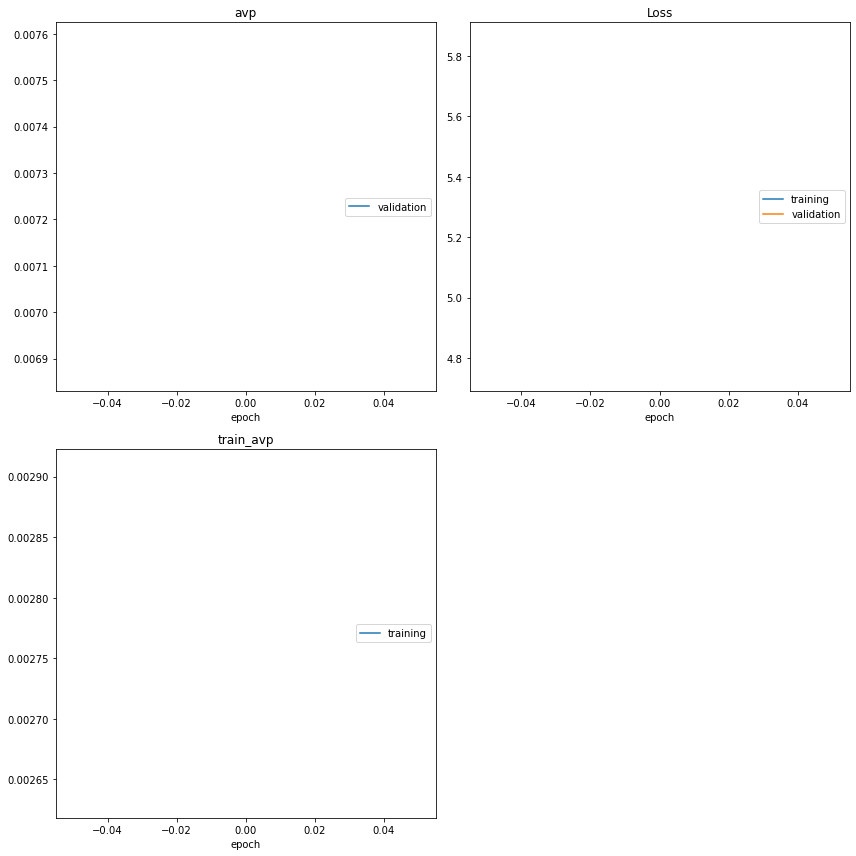

avp
	validation       	 (min:    0.007, max:    0.007, cur:    0.007)
Loss
	training         	 (min:    5.856, max:    5.856, cur:    5.856)
	validation       	 (min:    4.746, max:    4.746, cur:    4.746)
train_avp
	training         	 (min:    0.003, max:    0.003, cur:    0.003)


TypeError: can only concatenate str (not "int") to str

In [11]:
def saveModel(model,path):
    torch.save(model.state_dict(), path) 
path1="/projects/3027ef96-3bf3-48ec-b654-90936803b366/bestPerformanceDETR2.pth"  
path2="/projects/3027ef96-3bf3-48ec-b654-90936803b366/last_modelDETR.pth2"     
from torch.utils.tensorboard import SummaryWriter     
writer = SummaryWriter()

torch.cuda.empty_cache()


losses = [ 'boxes','labels']
criterion=SetCriterion(num_classes=model.num_classes,matcher=model.matcher, weight_dict=model.weight_dict, eos_coef=model.eos_coef, losses=losses) 
criterion.to(device)
BestValLoss=10
BestModel=model
for epoch in range(1, 400):
    
    loss,boxloss,avp,avp50,avp75,iou_classes=train(model, device, trainDataLoader, optimizer, epoch, criterion)
    
    lossV,avpV,avpV50,avpV75,iou_classesV=Validation(model,device, Val_dataLoader, criterion)
  
    if BestValLoss>lossV.item():
        BestValLoss=lossV.item()
        BestModel=model
    
    


    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', lossV.item(), epoch)
    writer.add_scalar('AP/train', avp, epoch)
    writer.add_scalar('Loss/train', avpV, epoch)
    writer.add_scalar('AP50/train', avp50, epoch)
    writer.add_scalar('AP50/val', avpV50, epoch)
    writer.add_scalar('AP75/train', avp75, epoch)
    writer.add_scalar('AP75/val', avpV75, epoch)
    
    for i in range(len(iou_classes)):
        writer.add_scalar('IOU_classes/train:'+str(i), iou_classes[i], epoch)
        writer.add_scalar('IOU_classes/Val:'+str(i), iou_classesV[i], epoch)
    
    scheduler.step()
    if epoch %10==0:
        saveModel(BestModel, path1)
    
 
#saveModel(BestModel,path1)   
#saveModel(model,path2)    

### load model weights

In [16]:
def LoadModel(modeltype):
    Path=''
    if modeltype=='best':
        Path="/projects/3027ef96-3bf3-48ec-b654-90936803b366/bestPerformanceDETR.pth"
    else:
        Path="/projects/3027ef96-3bf3-48ec-b654-90936803b366/last_modelDETR.pth"  
    model =build().to(device)    
    model.load_state_dict(torch.load(Path))
    model.eval()
    return model    

## Now that we´ve trained the Model to a reasonable performance lets define inference:

In [15]:

CLASSES =['N/A','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','0'] 

COLORS = [
    [0.000, 0.447, 0.741], 
    [0.850, 0.325, 0.098], 
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933]  
]
# Get coordinates (x0, y0, x1, y0) from model output (x, y, w, h)
def get_box_coords(boxes):
    x, y, w, h = boxes.unbind(1)
    x0, y0 = (x - 0.5 * w), (y - 0.5 * h)
    x1, y1 = (x + 0.5 * w), (y + 0.5 * h)
    box = [x0, y0, x1, y1]
    return torch.stack(box, dim=1)

# Scale box from [0,1]x[0,1] to [0, width]x[0, height]
def scale_boxes(output_box, width, height):
    box_coords = get_box_coords(output_box).to(
                 torch.cuda.current_device())
    scale_tensor = torch.Tensor(
                 [width, height, width, height]).to(
                 torch.cuda.current_device())
    return box_coords * scale_tensor
# Object Detection Pipeline

def detect(im, model, ):#transform):
    device = torch.device('cuda')
   
    width = 500#im.size()[0]
    height = 500#im.size()[1]
   
    # mean-std normalize the input image (batch-size: 1)
    img =im #transform(im)
    img= img.unsqueeze(0)
    img = img.to(device)
    
    # demo model only support by default images with aspect ratio    between 0.5 and 2
    #assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600,
    # propagate through the model
    
    outputs = model(img)
    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.70
    
    
    # convert boxes from [0; 1] to image scales
    x, y,w, h = outputs['pred_boxes'][0].unbind(1)
    x0,y0,x1,y1= renormBox(img, x,y,w,h)

    box = [x0.int(), y0.int(), x1.int(), y1.int()]
    box=torch.stack(box, dim=1)
    #bboxes_scaled = renormBox() #scale_boxes(outputs['pred_boxes'][0, keep], width, height)
    #print(outputs['pred_boxes'])
    
    return probas,box, keep#probas[keep], box[keep]

In [17]:
import torchvision.transforms as T
import torch.nn.functional as F
model2=LoadModel('best')


In [18]:
def renormBox(image,x,y,w,h):
        image.squeeze()
        
        width = image.size()[3]
        height = image.size()[2]
        print(width)
        print(height)
        
        x1=(x)*width
        x2=(x+w)*width
        y1=(y)*height
        y2=(y+h)*height
        
       
        return (x1,y1,x2,y2)
                
          

In [19]:
# Plot Predicted Bounding Boxes
def plot_results(pil_img, prob, boxes,labels=False):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    
    for prob, (x0, y0, x1, y1), color in zip(prob, boxes.tolist(),   COLORS * 100):  #(x0, y0, x1, y1), color in zip( boxes.tolist(),   COLORS * 100):# for prob, (x0, y0, x1, y1), color in zip(prob, boxes.tolist(),   COLORS * 100):
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,  
             fill=False, color=color, linewidth=2))
        cl = prob.argmax()
        
        text = f'{CLASSES[cl]}: {prob[cl]:0.2f}'
        if labels:
            ax.text(x0, y0, text, 
                    fontsize=15,
                bbox=dict(facecolor=color, alpha=0.75))
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


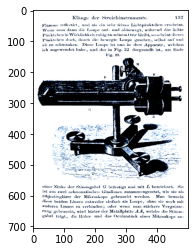

In [20]:
from PIL import Image
 # Sample image
img=valDataset[50][0]
plt.imshow(img.permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


500
705


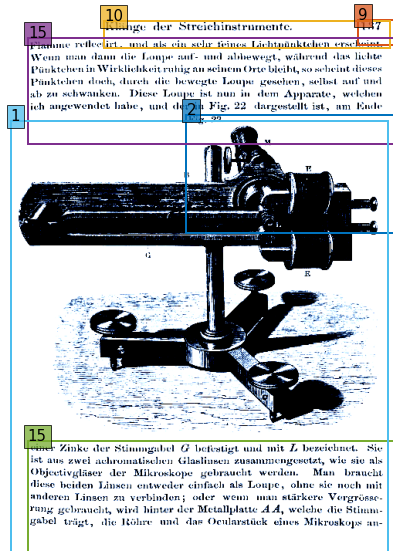

In [21]:
# visualize ground truth with image 
labels=valDataset[50][1][0]['labels']
boxes=valDataset[50][1][0]['boxes']
x, y, x1, y1 = boxes.unbind(1)
x0,y0,x1,y1= renormBox(img.unsqueeze(0), x,y,x1,y1)
box = [x0.int(), y0.int(), x1.int(), y1.int()]
box=torch.stack(box, dim=1)

plt.figure(figsize=(16,10))
plt.imshow(img.permute(1,2,0))
ax = plt.gca()
for  (x0, y0, x1, y1), color,label in zip(box.tolist(),   COLORS * 100,labels):
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,  
             fill=False, color=color, linewidth=2))
        
        
        text = f'{label}' 
        if label:
            ax.text(x0, y0, text, 
                    fontsize=15,
                bbox=dict(facecolor=color, alpha=0.75))
plt.axis('off')
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


500
705


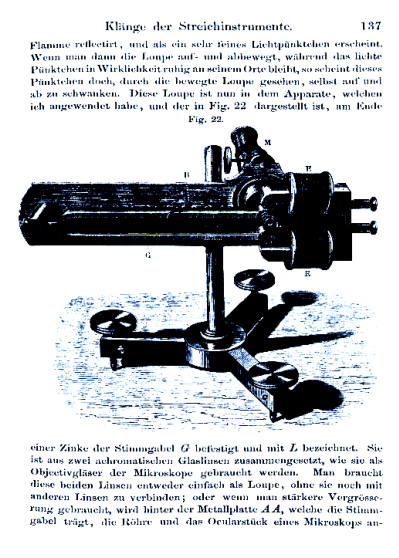

In [22]:
#visualize predictions with image
probas,boxes, keep=detect(img,model2)
plot_results(img.permute(1,2,0),probas[keep],boxes[keep], labels=True)
#prediction scores are below 70%; everything below will be not considered. Thats why nothing is shown below